In [1]:
import pickle
import torch as th
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
from datetime import datetime
from stable_baselines3 import DQN
import os
import gc

In [3]:
def get_q_values(model, obs , print_q_values = False):
        q_value = model.q_net(th.tensor(obs, device=model.device).unsqueeze(0)).detach().cpu().numpy().squeeze()  
        if print_q_values:
            print(f"Q-values: {q_value}")
        return q_value

def abstract_state_general_tuple(model, obs ,d, print_q_values = False):
        q_value = model.q_net(th.tensor(obs, device=model.device).unsqueeze(0)).detach().cpu().numpy().squeeze()  
        if print_q_values:
            print(f"Q-values: {q_value}")
        assert len(q_value) == 5, "logit length is not correct, it should be 5 for each action."
        Abs_state = np.ceil(q_value/d).astype(int)
        return tuple(Abs_state)

def to_pairwise_episodes(episode):
    pairwise = []
    for i in range(len(episode['obs'])):
        pairwise.append((episode['obs'][i], episode['action'][i]))
    return pairwise
def build_episodes(episodes):
    transformed_episodes = []
    for episode in episodes:
        transformed_episodes.append(to_pairwise_episodes(episode))
    return transformed_episodes

  
def Abstract_classes(ep,d,model):
  abs_states=[]
  for episode in ep:
    for state,action in episode:
      abs_st = abstract_state_general_tuple(model,state,d)
      if abs_st == 'end':
        continue
      abs_states.append(abs_st)  
  unique=list(set(abs_states))
  a=len(abs_states)
  b=len(set(abs_states))
  print("abstract states:",b)
  print("Concrete states",a)
  print("ratio",b/a)
  return unique

def is_functional_fault(episode,threshold):
  episode_length = len(episode)
  if episode_length<threshold:
    return True
  else:
    return False

def ML_second_representation_func_based(Abs_d,functional_func,model,input_episodes,Abs_classes,thr):
  """
  TO-DO : fix epsilon and threshold
  """
  data_x_b=[]
  data_y_f_b = []
  for i, episode in enumerate(input_episodes):
    record = np.zeros(len(Abs_classes))
    for state, action in episode:
      abs_state = abstract_state_general_tuple(model,state,Abs_d)
      if abs_state in Abs_classes:
        ind = Abs_classes.index(abs_state)
        record[ind] += 1
      else:
        assert False, "Abstract state not found in the list"
    if functional_func(episode, thr):
      data_y_f_b.append(1)
    else:
      data_y_f_b.append(0)
    data_x_b.append(record)
  assert len(data_y_f_b)==len(input_episodes), "X and Y are not the same length"
  return data_x_b, data_y_f_b

def report(model2,x_train, y_train,x_test, y_test):
  print("********************** reporting the result of the model **************************")
  print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
  print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


  predictions_train = model2.predict(x_train)
  predictions_test = model2.predict(x_test)

  print("\n\n--------------------------------------recall---------------------------------")

  print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
  print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

  print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
  print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


  print("\n\n--------------------------------------precision------------------------------")


  print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
  print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

  print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
  print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

  print("\n\n")
  print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

  tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
  specificity = tn / (tn+fp)
  print("\n\nspecifity :",specificity)
  print("\n\n--------------------------------------confusion----------------------------")
  CM = metrics.confusion_matrix(y_test, predictions_test)
  print("The confusion Matrix:")
  print(CM)
  print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
  print("********************** plotting the confusion matrix & ROC curve **************************")
  plot_confusion_matrix(model2, x_test, y_test)
  metrics.plot_roc_curve(model2, x_test, y_test) 
  plt.show()

# write function for load



In [4]:
def translator_frequency(episode,model, d, unique5):
  """
  thid function takes the concrete episodes and returns the encoded episodes 
  based on the presence and absence of the individuals  
  :param 'episode': input episode
  :param 'model': RL model
  :param 'd': abstraction level = 1
  :param 'unique5': abstract classes 
  :return: encoded episodse based on the presence and absence

  """
  
  record = np.zeros(len(unique5))
  for state, action in episode:
    ab = abstract_state_general_tuple(model,state,d)
    if ab == 'end':
      continue
    if ab in unique5:
      ind = unique5.index(ab)
      record[ind] += 1
  return [record]


def episode_player(episodes,d, abs_classes, model, monitor) -> list:
  ''' This function replays the episodes and returns the risk of each step in each episode
  :param 'episodes': input episodes
  :param 'd': abstraction level 
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in each episode
  
  '''
  episodes_risk=[]
  for episode in episodes:
    risk_array=[]
    for step in range(len(episode)-1):
      monitoring_data = translator_frequency(episode[:step],model,d,abs_classes)
      Risk = monitor.predict_proba(monitoring_data)
      risk_array.append(Risk[0][1])
    episodes_risk.append(risk_array)
  return episodes_risk

def single_episode_player(episode,d, abs_classes, model, monitor) -> list:
  ''' This function replays one episodes and returns the risk of each step in episode
  :param 'episode': input episode
  :param 'd': abstraction level
  :param 'abs_classes': abstract classes
  :param 'model': RL model
  :param 'monitor': ML model
  :return: risk of each step in episode
  '''
  risk_array=[]
  for step in range(len(episode)-1):
    monitoring_data = translator_frequency(episode[:step],model,d,abs_classes)
    Risk = monitor.predict_proba(monitoring_data)
    risk_array.append(Risk[0][1])
  return risk_array

def line_plot(data):
    plt.figure(figsize=(20, 6))
    for i in range(len(data)): 
        plt.plot( [i for i in range(len(data[i]))], data[i], label = f"Episode {i}")
    # plt.plot(y, x, label = "line 2")
        
    plt.legend()
    plt.show()

def plot_positions(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        position =[]
        position_arr =[]
        for j in range(len(episodes[i])-1):
            position.append(episodes[i][j][0][0])
        position_arr.append(position)
        plt.plot([i for i in range(len(position))], position, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def plot_velocity(episodes):
    plt.figure(figsize=(20, 6))
    
    for i in range(len(episodes)):
        velocity =[]
        velocity_arr =[]
        for j in range(len(episodes[i])-1):
            velocity.append(episodes[i][j][0][1])
        velocity_arr.append(velocity)
        plt.plot([i for i in range(len(velocity))], velocity, label = f"Episode {i}")
        
    plt.legend()
    plt.show()

def position_extractor(episode):
    position =[]
    for i in range(len(episode)-1):
        position.append(episode[i][0][0])
    return position
    
def velocity_extractor(episode):
    velocity =[]
    for i in range(len(episode)-1):
        velocity.append(episode[i][0][1])
    return velocity


def Plot_all(data, params,save=False,show=True,data_chunk=0,path='Plots/v2'):
    '''plot risk and position snd velocity in one figure with 3 subplots
    '''
    d,unique1,model,RF_FF_1rep = params
    fig, axs = plt.subplots(3,figsize=(20, 18))
    for i in range(len(data)):
        axs[0].plot([i for i in range(len(data[i])-1)], single_episode_player(data[i],d,unique1,model,RF_FF_1rep), label = f"Episode {i}")
        axs[1].plot([i for i in range(len(data[i])-1)], position_extractor(data[i]), label = f"Episode {i}")
        axs[2].plot([i for i in range(len(data[i])-1)], velocity_extractor(data[i]), label = f"Episode {i}")
    axs[0].legend()
    axs[0].set_title('Risk')
    axs[1].set_title('Position')
    axs[2].set_title('Velocity')
    axs[1].legend()
    axs[2].legend()
    axs[0].set_ylim(-0.1,1.1)
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    if save:
        fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    plt.close()
    


In [5]:
def report_and_save(model2,x_train, y_train,x_test, y_test, save=False,abs_d=None, save_path=None):
    print("********************** reporting the result of the model **************************")
    print('The score for train data is {0}'.format(model2.score(x_train,y_train)))
    print('The score for test data is {0}'.format(model2.score(x_test,y_test)))


    predictions_train = model2.predict(x_train)
    predictions_test = model2.predict(x_test)

    print("\n\n--------------------------------------recall---------------------------------")

    print('the test recall for the class yes is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
    print('the test recall for the class no is {0}'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

    print('the training recall for the class yes is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
    print('the training recall for the class no is {0}'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))


    print("\n\n--------------------------------------precision------------------------------")


    print('the test precision for the class yes is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
    print('the test precision for the class no is {0}'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

    print('the training precision for the class yes is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
    print('the training precision for the class no is {0}'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

    print("\n\n")
    print(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

    tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
    specificity = tn / (tn+fp)
    print("\n\nspecifity :",specificity)
    print("\n\n--------------------------------------confusion----------------------------")
    CM = metrics.confusion_matrix(y_test, predictions_test)
    print("The confusion Matrix:")
    print(CM)
    print('the accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
    print("********************** plotting the confusion matrix & ROC curve **************************")
    plot_confusion_matrix(model2, x_test, y_test)
    metrics.plot_roc_curve(model2, x_test, y_test) 
    plt.show()
    if save:
        with open(f'{save_path}/model_{abs_d}_report.txt', 'w') as f:
            f.write("********************** reporting the result of the model **************************\n")
            f.write('The score for train data is {0}\n'.format(model2.score(x_train,y_train)))
            f.write('The score for test data is {0}\n'.format(model2.score(x_test,y_test)))

            predictions_train = model2.predict(x_train)
            predictions_test = model2.predict(x_test)

            f.write("\n\n--------------------------------------recall---------------------------------\n")

            f.write('the test recall for the class yes is {0}\n'.format(metrics.recall_score(y_test,predictions_test, pos_label=1)))
            f.write('the test recall for the class no is {0}\n'.format(metrics.recall_score(y_test,predictions_test, pos_label=0)))

            f.write('the training recall for the class yes is {0}\n'.format(metrics.recall_score(y_train,predictions_train, pos_label=1)))
            f.write('the training recall for the class no is {0}\n'.format(metrics.recall_score(y_train,predictions_train, pos_label=0)))

            f.write("\n\n--------------------------------------precision------------------------------\n")

            f.write('the test precision for the class yes is {0}\n'.format(metrics.precision_score(y_test,predictions_test, pos_label=1)))
            f.write('the test precision for the class no is {0}\n'.format(metrics.precision_score(y_test,predictions_test, pos_label=0)))

            f.write('the training precision for the class yes is {0}\n'.format(metrics.precision_score(y_train,predictions_train, pos_label=1)))
            f.write('the training precision for the class no is {0}\n'.format(metrics.precision_score(y_train,predictions_train, pos_label=0)))

            f.write("\n\n")
            f.write(classification_report(y_test, predictions_test, target_names=['NO ','yes']))

            tn, fp, fn, tp = confusion_matrix(y_test, predictions_test).ravel()
            specificity = tn / (tn+fp)
            f.write("\n\nspecifity :{0}\n".format(specificity))
            f.write("\n\n--------------------------------------confusion----------------------------\n")
            CM = metrics.confusion_matrix(y_test, predictions_test)
            f.write("The confusion Matrix:\n")
            f.write(str(CM))
            f.write('\nthe accuracy score in {0}\n\n'.format(accuracy_score(y_test, predictions_test)))
            f.write("********************** plotting the confusion matrix & ROC curve **************************\n")


In [6]:
import scipy
import pandas as pd
def translate_multiple_episodes_steps(episodes,RL_model,translator,d,abs_classes):
    translated_episodes = []
    for episode in episodes:
        translated_buffer = []
        for i in range(len(episode)):
            translated_buffer.append(translator(episode[:i],RL_model,d,abs_classes))
        translated_episodes.append(translated_buffer)
    return translated_episodes



def Forest_CI_multiple(translated_episodes,HD_model,chunk,abs_d,thr,path = 'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots2/CI'):
    '''
    size of translated_episodes is limited by the number of colors available for one plot
    '''
    plt.figure(figsize=(20, 12))
    results_Arr=[]
    r_arr=[]
    E=0
    colors = ['red','blue','green','yellow','black','purple','orange','pink','brown','grey','cyan','magenta','lime','olive','teal','navy','maroon','violet','turquoise','salmon','gold','coral','indigo','crimson','azure','beige','chocolate','lavender','plum','orchid','tan','khaki','wheat','silver','sienna','peru','peachpuff','papayawhip','mistyrose','moccasin','lemonchiffon','lawngreen','lightgreen','limegreen']
    for translated_episode , plt_color in zip(translated_episodes,colors[:len(translated_episodes)]):
        E+=1
        num_time_steps = len(translated_episode) # Number of time steps
        num_trees = HD_model.n_estimators
        predictions = np.zeros((num_time_steps, num_trees))
        for i, tree in enumerate(HD_model.estimators_):
            for j in range(len(translated_episode)):
                Risk = tree.predict_proba(translated_episode[j])[0][1]
                predictions[j, i] = Risk
        # Calculate the mean prediction for each time step
        mean_predictions = np.mean(predictions, axis=1)

        # Calculate the standard deviation for each time step
        std_predictions = np.std(predictions, axis=1)

        # Calculate the lower and upper bounds for the confidence intervals
        confidence_level = 0.95 # Change as needed
        z_score = scipy.stats.norm.ppf((1 + confidence_level) / 2)
        lower_bounds = mean_predictions - z_score * std_predictions / np.sqrt(num_trees)
        upper_bounds = mean_predictions + z_score * std_predictions / np.sqrt(num_trees)
        difference = upper_bounds - lower_bounds
        # Store the results in a dataframe
        results = pd.DataFrame({
            'Mean prediction': mean_predictions,
            'Lower bound': lower_bounds,
            'Upper bound': upper_bounds
        })
        # Save the results to a file
        results_Arr.append(results)
        r_arr.append([mean_predictions, lower_bounds, upper_bounds,difference])
        plt.fill_between(range(num_time_steps), lower_bounds, upper_bounds, color=plt_color, alpha=0.2)
        # print(len(translated_episode))
        # assert False, "stop"
        if is_functional_fault(translated_episode, thr):
            plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}-sv',linestyle='--')
        else:
            plt.plot(mean_predictions, color=plt_color, label=f'Episode {E}')

        # Add labels and title to the plot
        plt.xlabel('Time step')
        plt.ylabel('Prediction')
        plt.title('Confidence Intervals of Random Forest Predictions')
    # results_arr.append(r_arr)
    # Save the plot as a file
    current_time = datetime.now()
    ID = current_time.strftime("%Y%m%d%H%M%S")
    # if save:
    #     fig.savefig(f'{path}/RPV_C{data_chunk}_{ID}.png')
    # plt.savefig(f'C:/Users/Student/Desktop/vs_git/HazardDetection/Plots/CI/abs_{d}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.legend()
    plt.savefig(f'{path}/confidence_intervals_{chunk}_{ID}.png', bbox_inches='tight')
    plt.close()
    # np.array(results_Arr).to_csv('confidence_intervals.csv', index=False)
    # save results_arr to pickle file
    pickle_path = f'{path}/CI/Abs_{abs_d}'
    if not os.path.exists(pickle_path):
        os.makedirs(pickle_path)
    with open(f'{pickle_path}/results_arr_{chunk}.pkl', 'wb') as f:
        pickle.dump(r_arr, f)


In [7]:
def number_of_functional_faults(episodes,thr):
    count=0
    for ep in episodes:
        if is_functional_fault(ep, thr):
            count+=1
    return count


Number of functional faults in the final episodes: 222
Number of functional faults in the test episodes: 59
Abstraction level: 100
Abstraction data for d=100 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

      

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


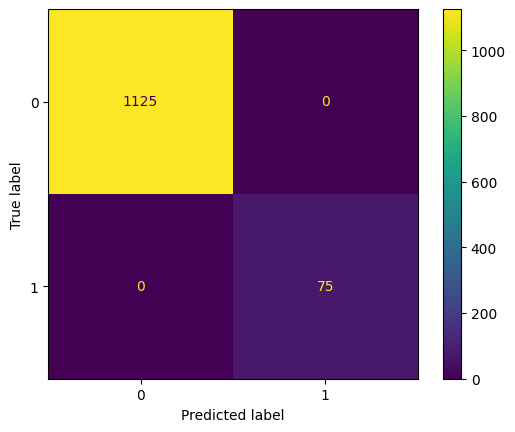

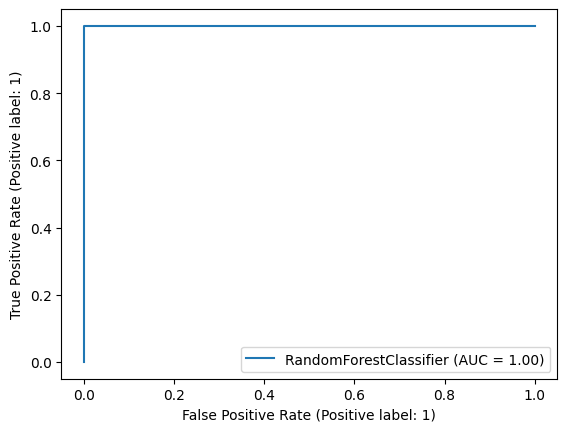

Abstraction data for d=100 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:50<00:00,  5.52s/it]


Abstraction level: 50
Abstraction data for d=50 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    acc

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


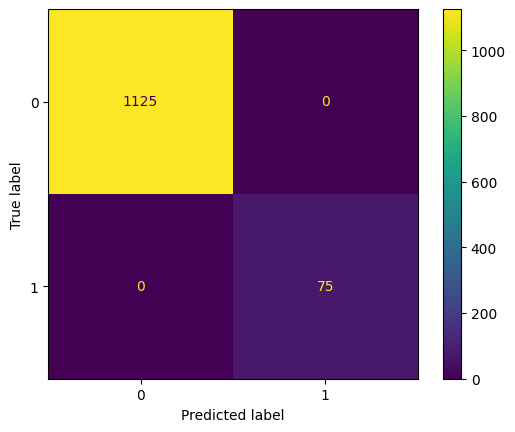

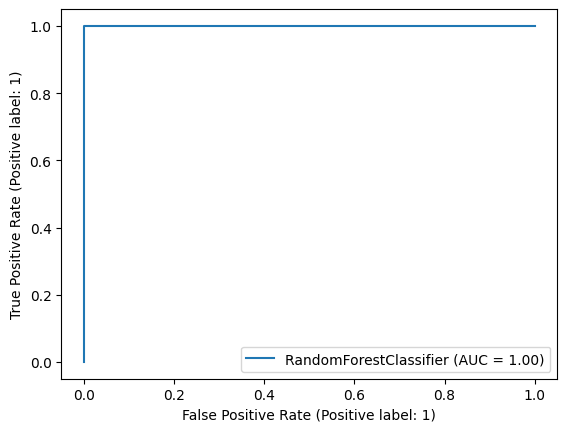

Abstraction data for d=50 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


Abstraction level: 10
Abstraction data for d=10 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    acc

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


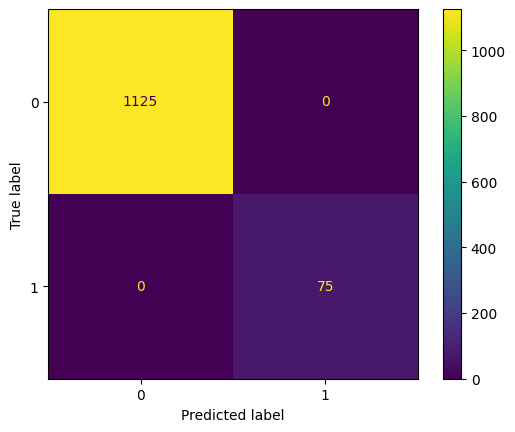

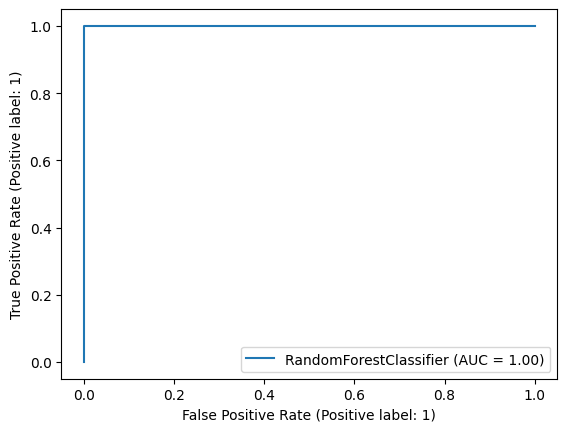

Abstraction data for d=10 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:43<00:00,  5.19s/it]


Abstraction level: 9
Abstraction data for d=9 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    accur

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


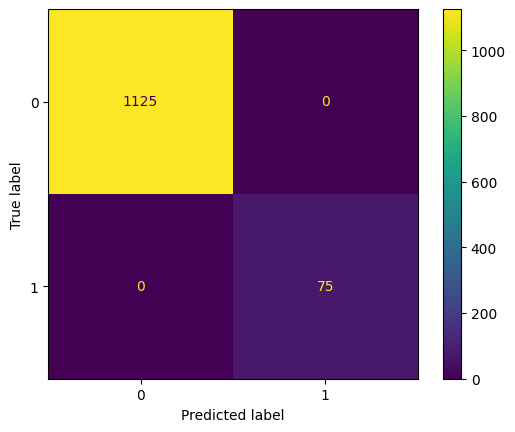

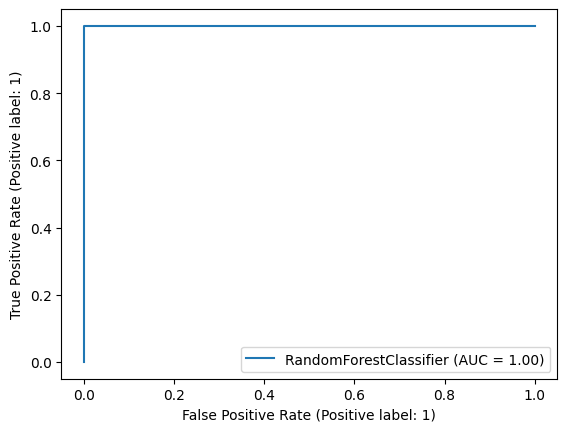

Abstraction data for d=9 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


Abstraction level: 8
Abstraction data for d=8 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    accur

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


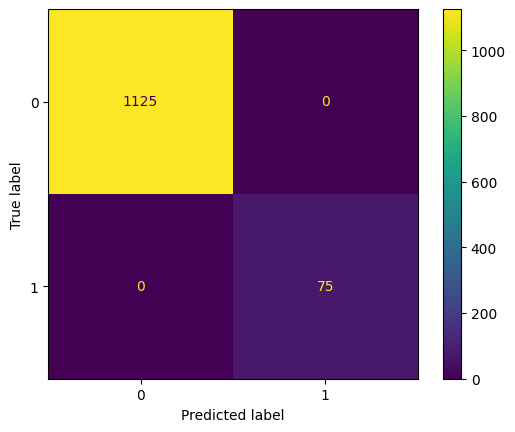

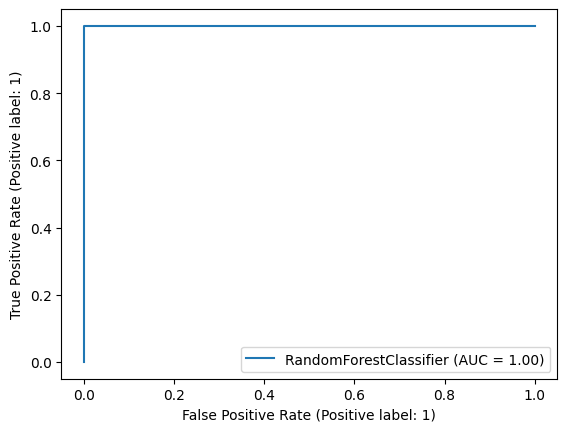

Abstraction data for d=8 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:44<00:00,  5.23s/it]


Abstraction level: 7
Abstraction data for d=7 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    accur

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


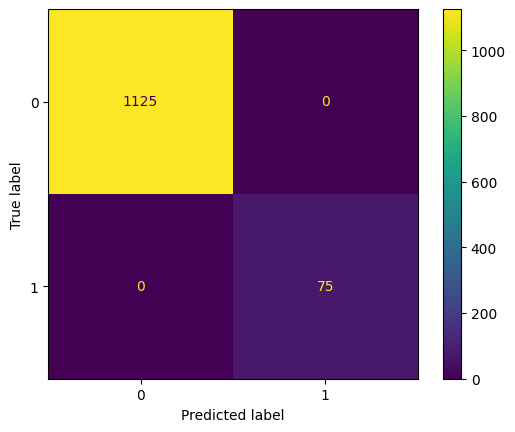

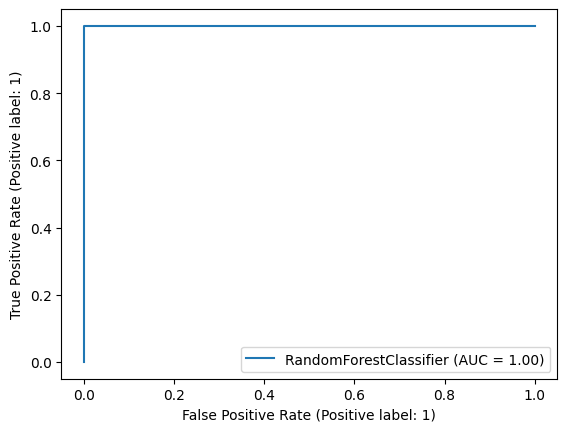

Abstraction data for d=7 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:52<00:00,  5.64s/it]


Abstraction level: 6
Abstraction data for d=6 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    accur

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


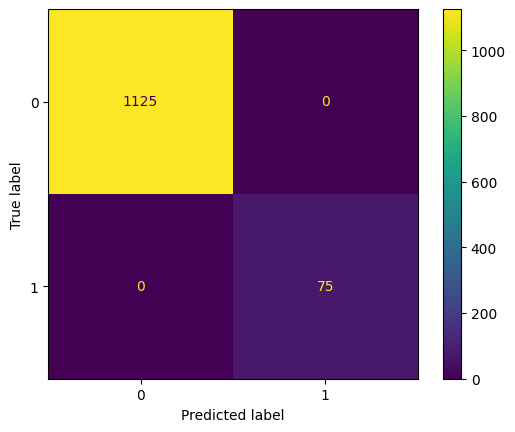

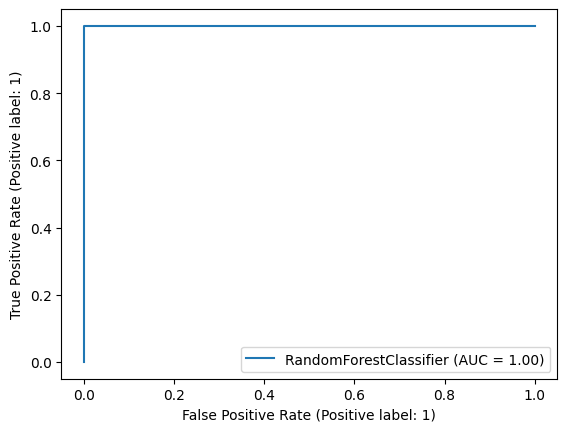

Abstraction data for d=6 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:52<00:00,  5.63s/it]


Abstraction level: 5
Abstraction data for d=5 does not exist, creating new one
abstract states: 16
Concrete states 115730
ratio 0.00013825282986261125
shape of data 16
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9958333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9733333333333334
the test recall for the class no is 0.9973333333333333
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9605263157894737
the test precision for the class no is 0.998220640569395
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


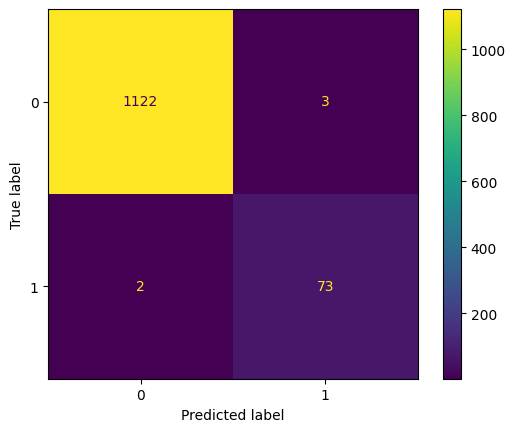

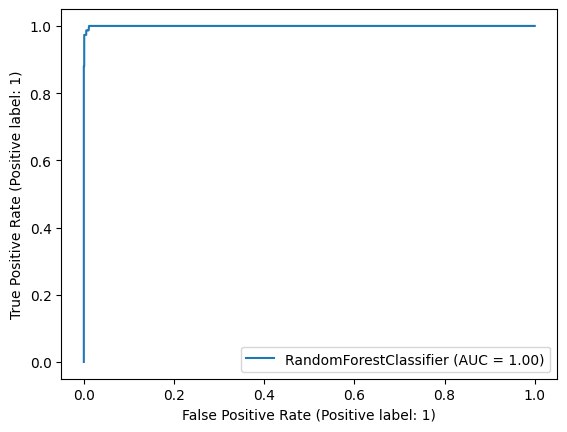

Abstraction data for d=5 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:15<00:00,  6.78s/it]


Abstraction level: 4
Abstraction data for d=4 does not exist, creating new one
abstract states: 2
Concrete states 115730
ratio 1.7281603732826406e-05
shape of data 2
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9991666666666666


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9866666666666667
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9991119005328597
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes      

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


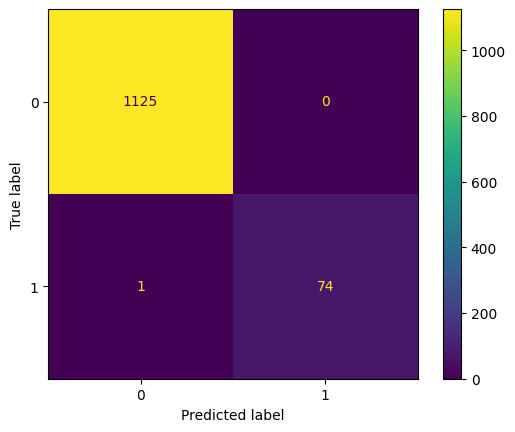

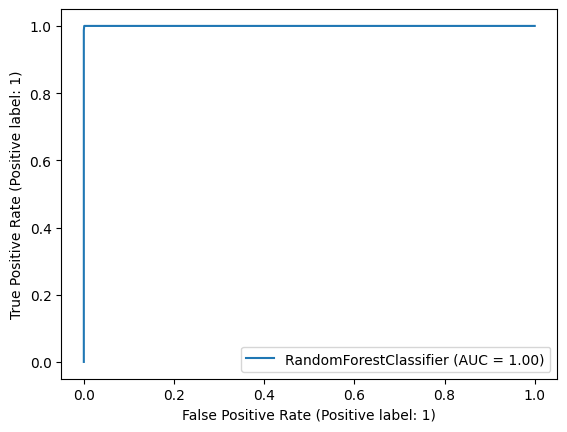

Abstraction data for d=4 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:46<00:00,  5.32s/it]


Abstraction level: 3
Abstraction data for d=3 does not exist, creating new one
abstract states: 1
Concrete states 115730
ratio 8.640801866413203e-06
shape of data 1
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 1.0


--------------------------------------recall---------------------------------
the test recall for the class yes is 1.0
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 1.0
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes       1.00      1.00      1.00        75

    accur

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


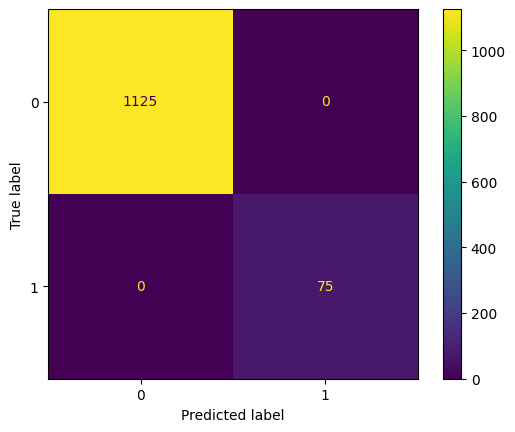

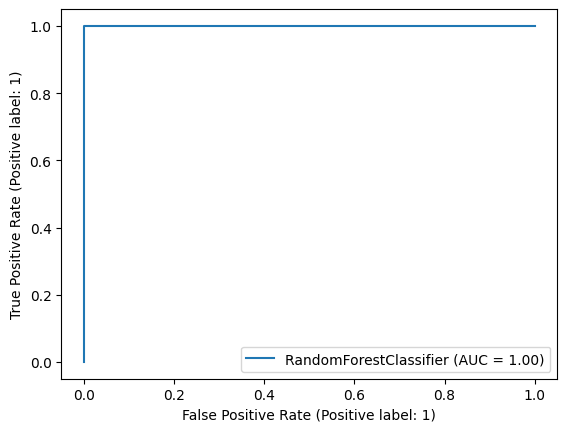

Abstraction data for d=3 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:45<00:00,  5.28s/it]


Abstraction level: 2
Abstraction data for d=2 does not exist, creating new one
abstract states: 2
Concrete states 115730
ratio 1.7281603732826406e-05
shape of data 2
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9991666666666666


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9866666666666667
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9991119005328597
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.00      1125
         yes      

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


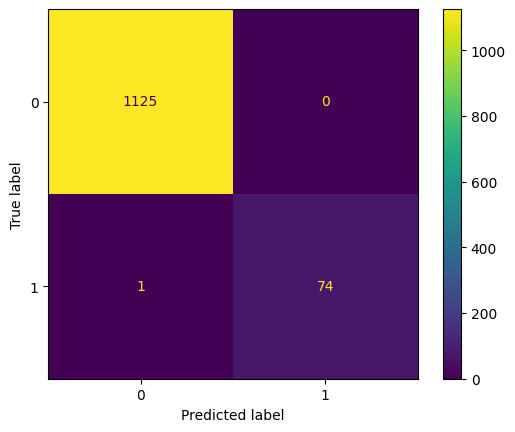

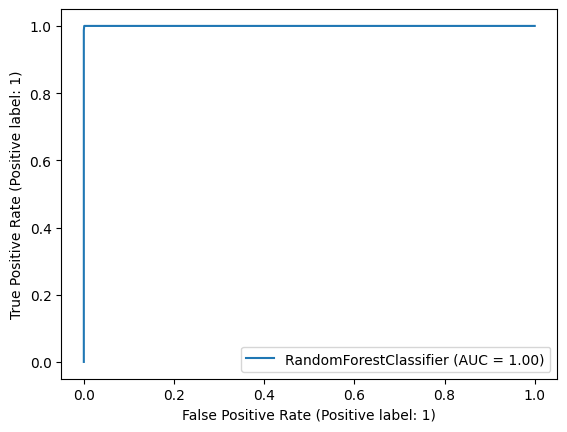

Abstraction data for d=2 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:47<00:00,  5.38s/it]


Abstraction level: 1
Abstraction data for d=1 does not exist, creating new one
abstract states: 17
Concrete states 115730
ratio 0.00014689363172902444
shape of data 17
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9958333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9733333333333334
the test recall for the class no is 0.9973333333333333
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9605263157894737
the test precision for the class no is 0.998220640569395
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00      1.

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


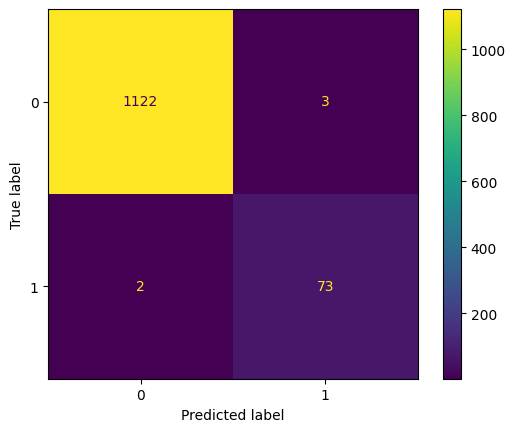

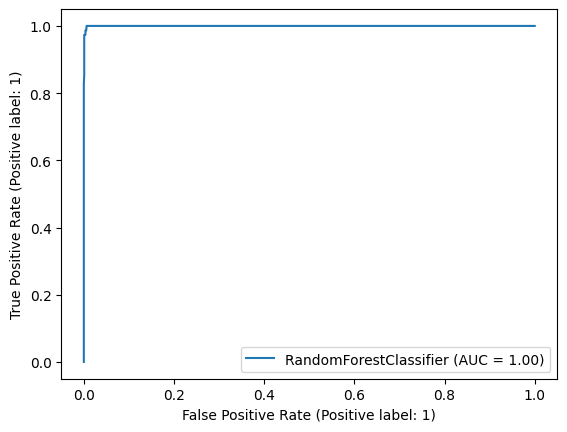

Abstraction data for d=1 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:48<00:00,  5.40s/it]


Abstraction level: 0.9
Abstraction data for d=0.9 does not exist, creating new one
abstract states: 12
Concrete states 115730
ratio 0.00010368962239695844
shape of data 12
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9916666666666667


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9333333333333333
the test recall for the class no is 0.9955555555555555
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9333333333333333
the test precision for the class no is 0.9955555555555555
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        1.00      1.00   

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


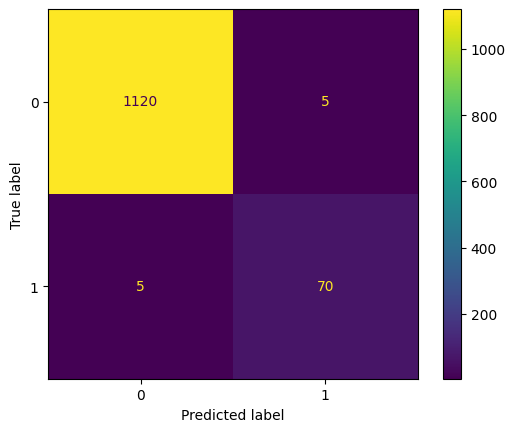

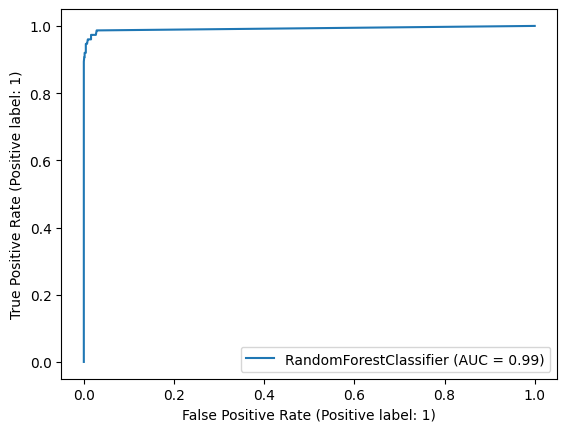

Abstraction data for d=0.9 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:51<00:00,  5.59s/it]


Abstraction level: 0.8
Abstraction data for d=0.8 does not exist, creating new one
abstract states: 24
Concrete states 115730
ratio 0.00020737924479391688
shape of data 24
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9925


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9066666666666666
the test recall for the class no is 0.9982222222222222
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9714285714285714
the test precision for the class no is 0.9938053097345133
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      1.00     

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


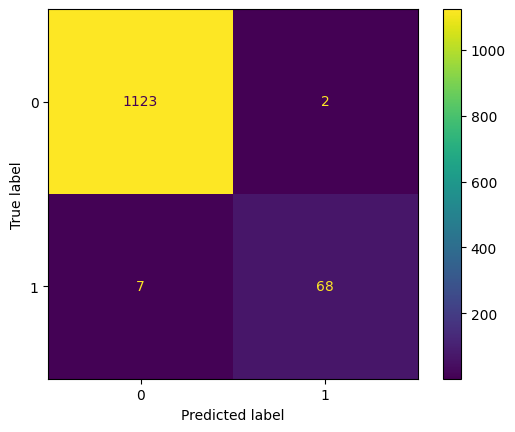

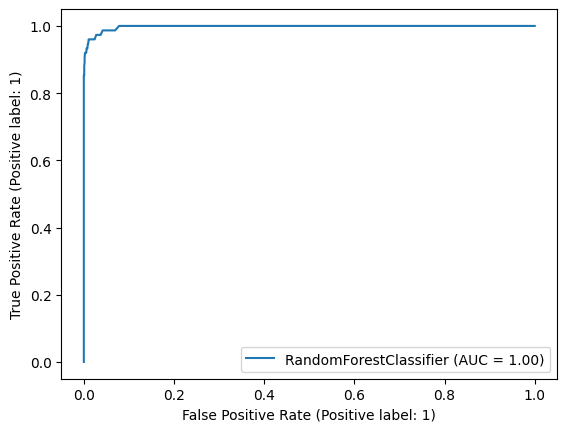

Abstraction data for d=0.8 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:48<00:00,  5.43s/it]


Abstraction level: 0.7
Abstraction data for d=0.7 does not exist, creating new one
abstract states: 30
Concrete states 115730
ratio 0.0002592240559923961
shape of data 30
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9875


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8266666666666667
the test recall for the class no is 0.9982222222222222
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.96875
the test precision for the class no is 0.988556338028169
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99      1125
       

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


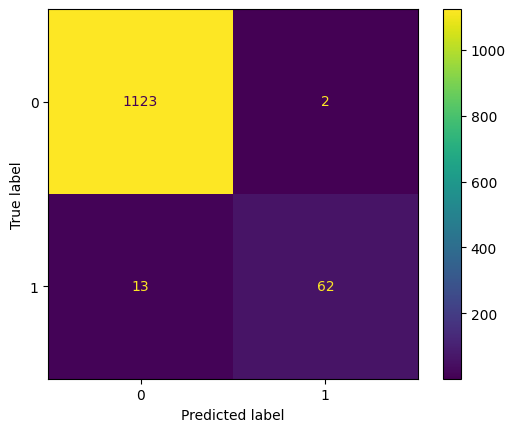

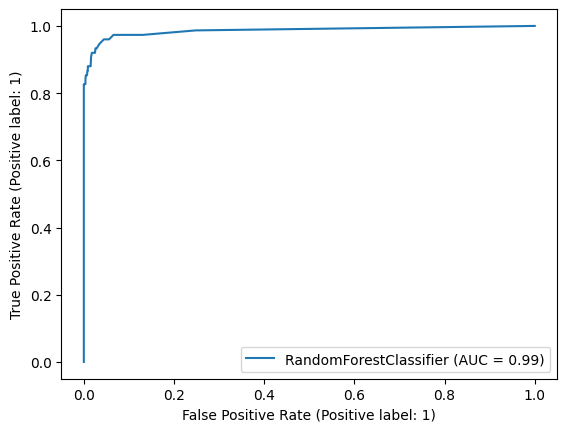

Abstraction data for d=0.7 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:46<00:00,  5.32s/it]


Abstraction level: 0.6
Abstraction data for d=0.6 does not exist, creating new one
abstract states: 29
Concrete states 115730
ratio 0.00025058325412598287
shape of data 29
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.99


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.88
the test recall for the class no is 0.9973333333333333
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9565217391304348
the test precision for the class no is 0.9920424403183024
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99      1125
         y

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


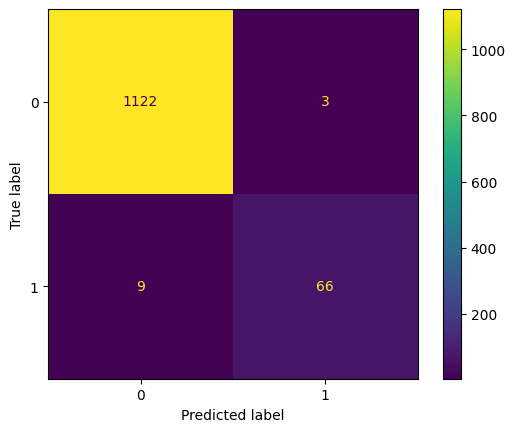

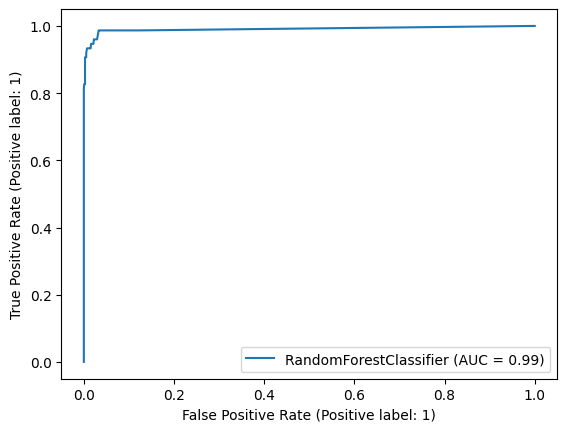

Abstraction data for d=0.6 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:55<00:00,  5.75s/it]


Abstraction level: 0.5
Abstraction data for d=0.5 does not exist, creating new one
abstract states: 34
Concrete states 115730
ratio 0.0002937872634580489
shape of data 34
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9916666666666667


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.9066666666666666
the test recall for the class no is 0.9973333333333333
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9577464788732394
the test precision for the class no is 0.9937998228520815
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00    

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


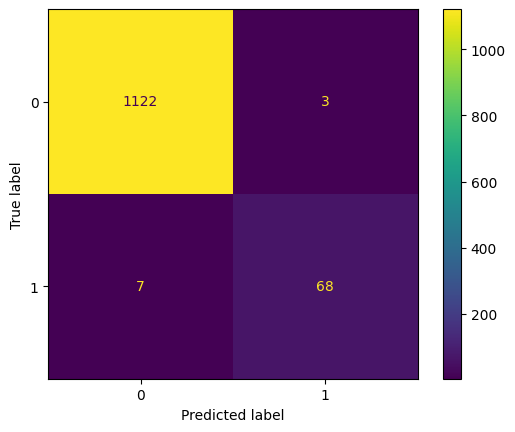

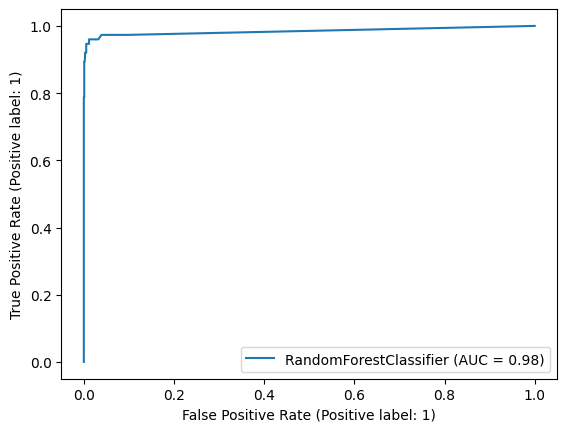

Abstraction data for d=0.5 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:04<00:00,  6.20s/it]


Abstraction level: 0.4
Abstraction data for d=0.4 does not exist, creating new one
abstract states: 44
Concrete states 115730
ratio 0.0003801952821221809
shape of data 44
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9841666666666666


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8
the test recall for the class no is 0.9964444444444445
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9375
the test precision for the class no is 0.9867957746478874
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99      1125
         y

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


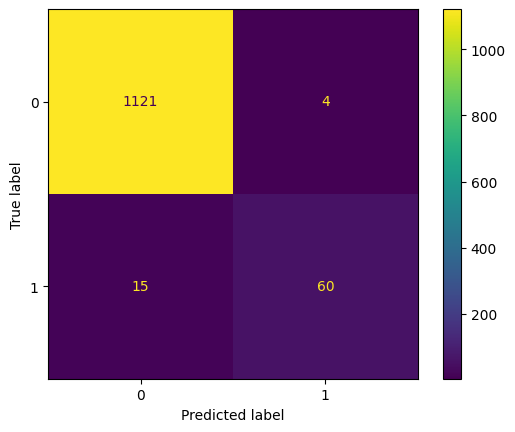

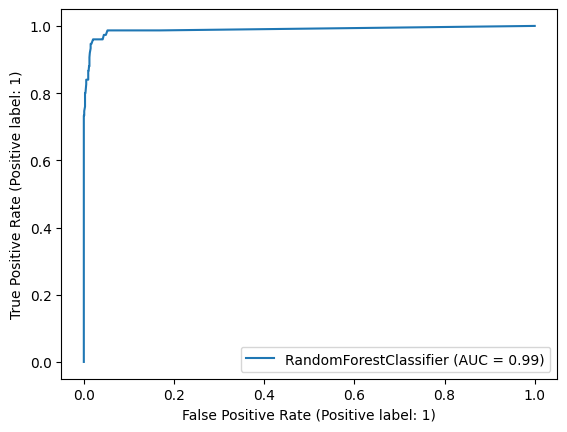

Abstraction data for d=0.4 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


Abstraction level: 0.35
Abstraction data for d=0.35 does not exist, creating new one
abstract states: 62
Concrete states 115730
ratio 0.0005357297157176186
shape of data 62
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9866666666666667


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8
the test recall for the class no is 0.9991111111111111
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9836065573770492
the test precision for the class no is 0.9868305531167691
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99      1

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


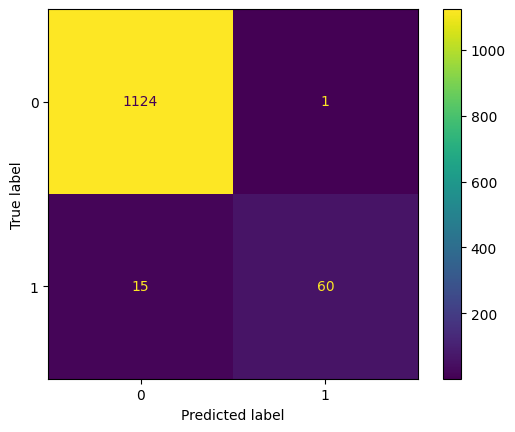

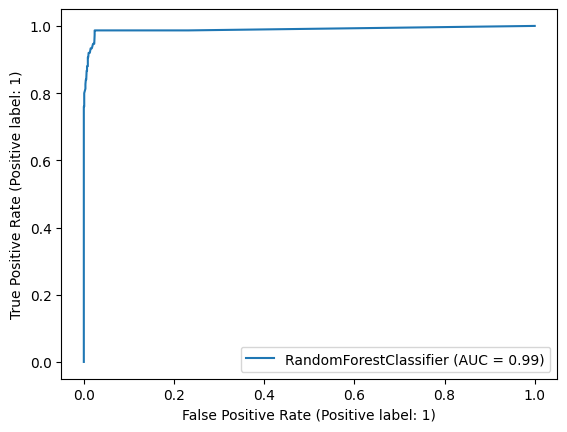

Abstraction data for d=0.35 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:48<00:00,  5.41s/it]


Abstraction level: 0.3
Abstraction data for d=0.3 does not exist, creating new one
abstract states: 69
Concrete states 115730
ratio 0.000596215328782511
shape of data 69
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.985


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7733333333333333
the test recall for the class no is 0.9991111111111111
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9830508474576272
the test precision for the class no is 0.9851007887817704
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99      11

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


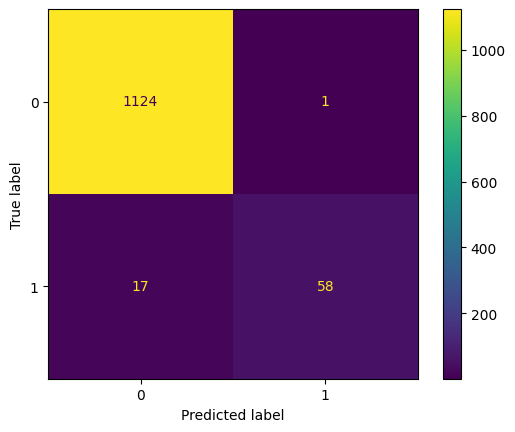

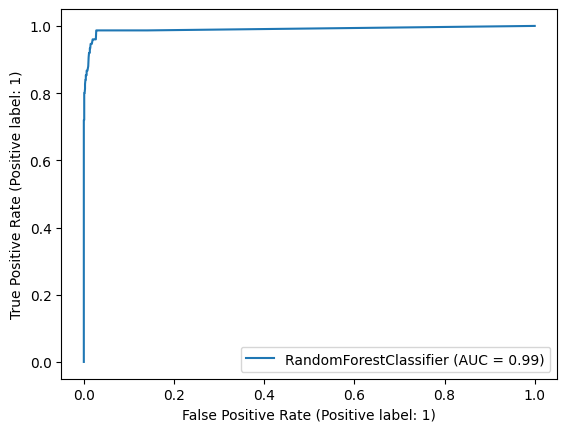

Abstraction data for d=0.3 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


Abstraction level: 0.2
Abstraction data for d=0.2 does not exist, creating new one
abstract states: 136
Concrete states 115730
ratio 0.0011751490538321955
shape of data 136
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.985


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8133333333333334
the test recall for the class no is 0.9964444444444445
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9384615384615385
the test precision for the class no is 0.9876651982378855
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      1.00      0.99     

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


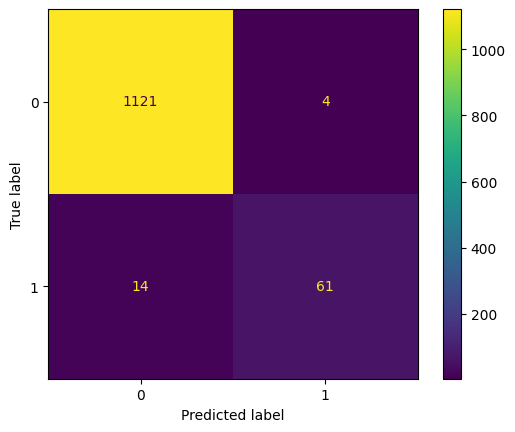

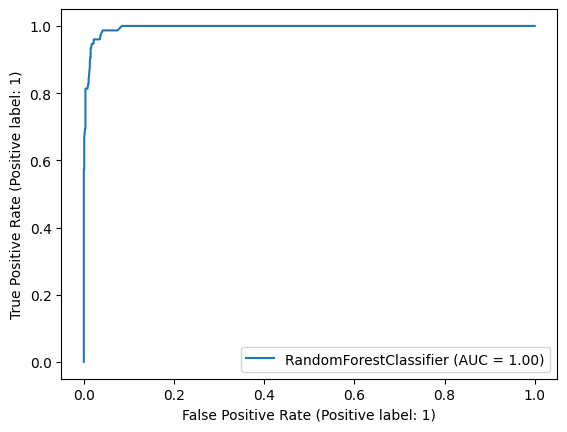

Abstraction data for d=0.2 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


Abstraction level: 0.15
Abstraction data for d=0.15 does not exist, creating new one
abstract states: 229
Concrete states 115730
ratio 0.0019787436274086236
shape of data 229
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.98


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7466666666666667
the test recall for the class no is 0.9955555555555555
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.9180327868852459
the test precision for the class no is 0.9833187006145742
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.98      1.00      0.99    

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


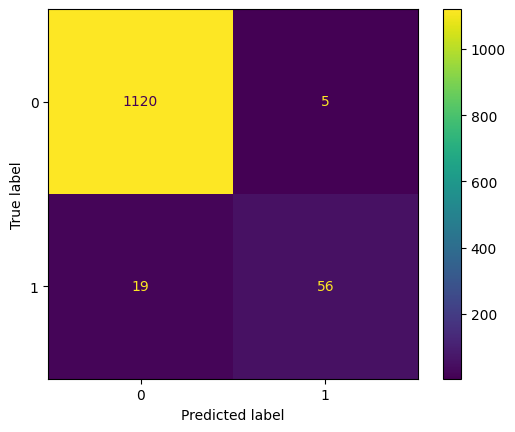

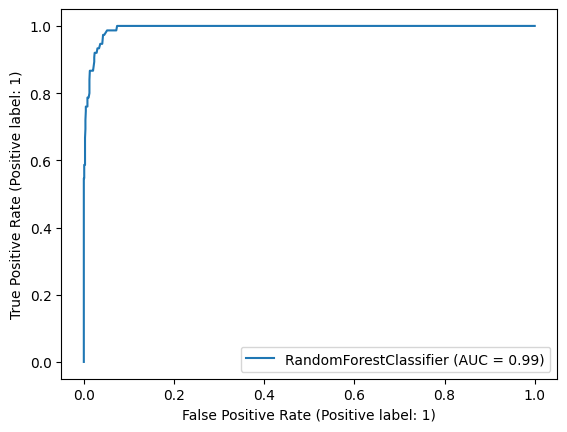

Abstraction data for d=0.15 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:29<00:00,  7.46s/it]


Abstraction level: 0.1
Abstraction data for d=0.1 does not exist, creating new one
abstract states: 520
Concrete states 115730
ratio 0.0044932169705348655
shape of data 520
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9791666666666666


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8
the test recall for the class no is 0.9911111111111112
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.8571428571428571
the test precision for the class no is 0.9867256637168141
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      0.99      0.99      1

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


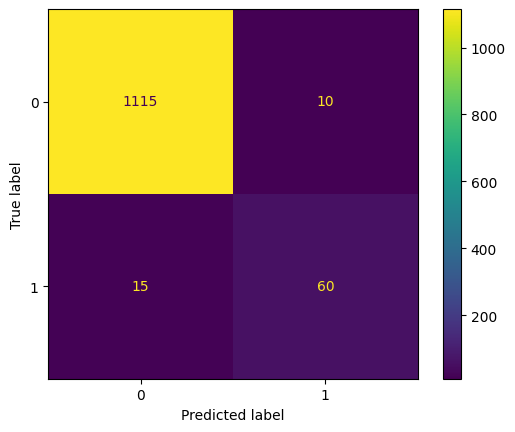

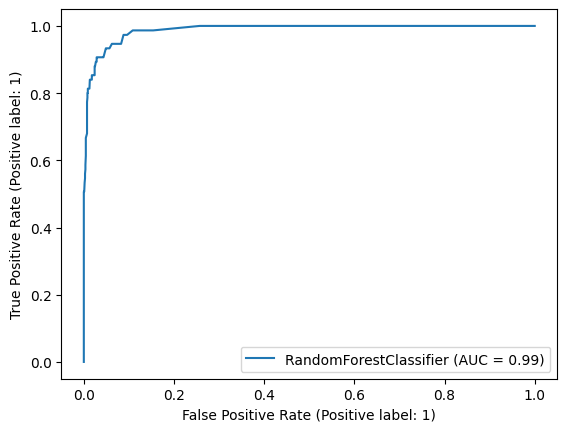

Abstraction data for d=0.1 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:30<00:00,  7.54s/it]


Abstraction level: 0.08
Abstraction data for d=0.08 does not exist, creating new one
abstract states: 821
Concrete states 115730
ratio 0.0070940983323252394
shape of data 821
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.975


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8133333333333334
the test recall for the class no is 0.9857777777777778
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.7922077922077922
the test precision for the class no is 0.98753339269813
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      0.99      0.99     

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


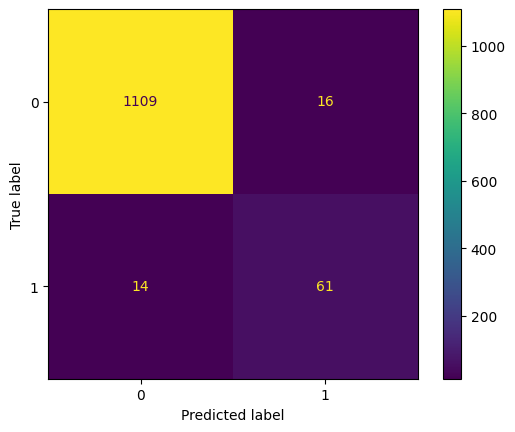

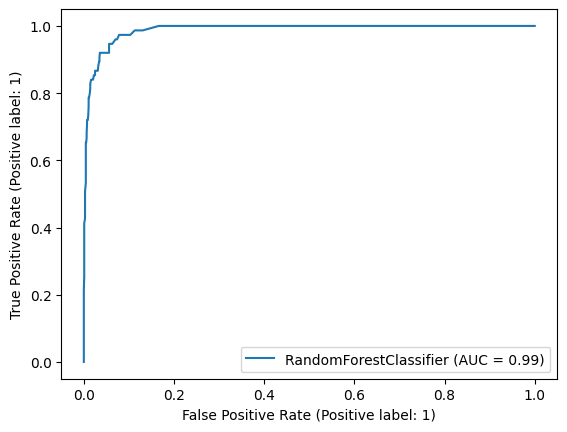

Abstraction data for d=0.08 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:04<00:00,  6.21s/it]


Abstraction level: 0.06
Abstraction data for d=0.06 does not exist, creating new one
abstract states: 1537
Concrete states 115730
ratio 0.013280912468677093
shape of data 1537
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9708333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.8
the test recall for the class no is 0.9822222222222222
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.75
the test precision for the class no is 0.9866071428571429
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.99      0.98      0.98      1125
       

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


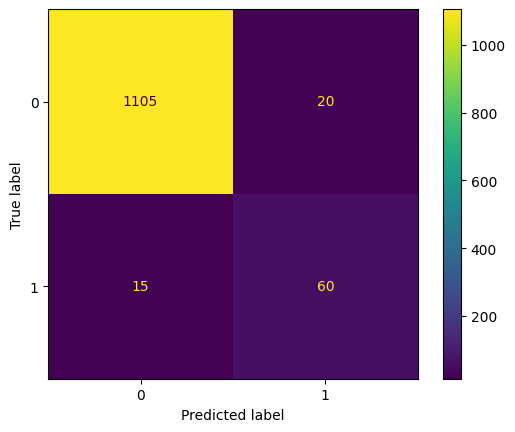

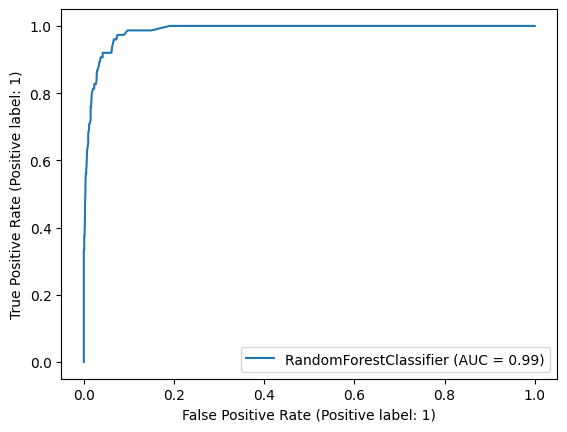

Abstraction data for d=0.06 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:14<00:00,  6.71s/it]


Abstraction level: 0.03
Abstraction data for d=0.03 does not exist, creating new one
abstract states: 7043
Concrete states 115730
ratio 0.06085716754514819
shape of data 7043
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.96


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.5466666666666666
the test recall for the class no is 0.9875555555555555
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.7454545454545455
the test precision for the class no is 0.9703056768558952
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.97      0.99      0.98    

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


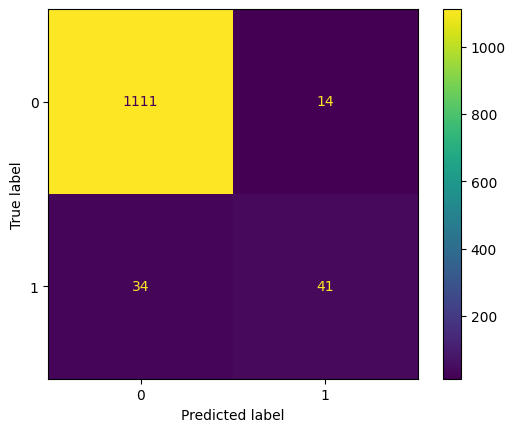

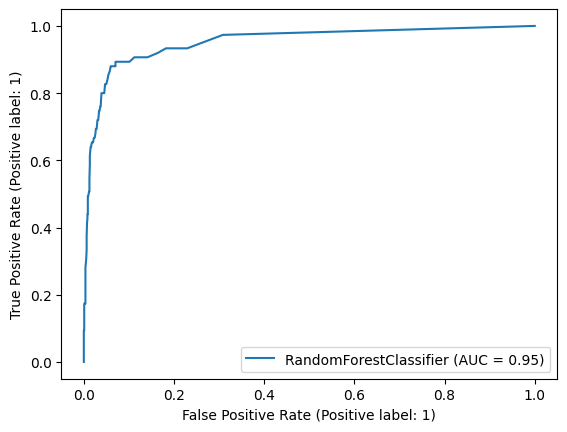

Abstraction data for d=0.03 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [03:08<00:00,  9.42s/it]


Abstraction level: 0.01
Abstraction data for d=0.01 does not exist, creating new one
abstract states: 54107
Concrete states 115730
ratio 0.4675278665860192
shape of data 54107
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9383333333333334


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.013333333333333334
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9382819015846539
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.94      1.00      0.97      1125
      

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


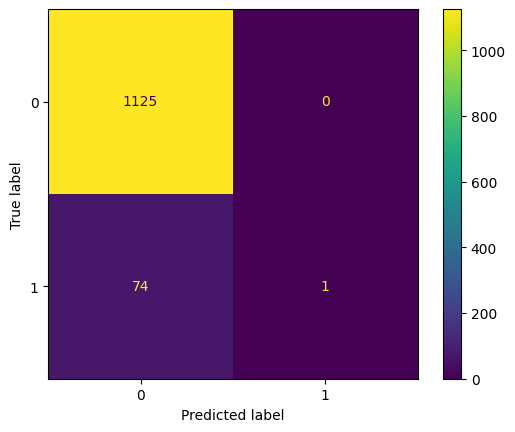

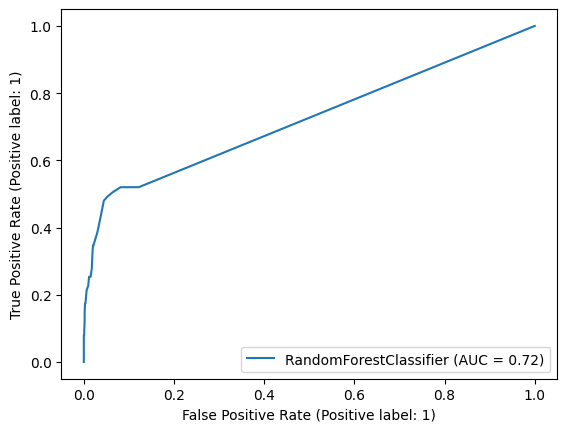

Abstraction data for d=0.01 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [19:55<00:00, 59.75s/it]


In [13]:
from tqdm import tqdm
model  = DQN.load("HighwayEnv/training_checkpoints_CP_10_arch_64by2/SB3_DQN_highway_fast_50sec_CP10_arch_64by2_70000_steps.zip")
threshold = 30

d_set= [100,
        50,
        10,
        9,
        8,
        7,
        6,
        5,
        4,
        3,
        2,
        1,
        0.9,
        0.8,
        0.7,
        0.6,
        0.5,
        0.4,
        0.35,
        0.3,
        0.2,
        0.15,
        0.1,
        0.08,
        0.06,
        0.03,
        0.01]

#load ml training data
with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_test_4000_SV222_Rate0.0555.pkl', 'rb') as file2:
    final_episodes = pickle.load(file2)

final_episodes = final_episodes[:4000]
final_episodes = build_episodes(final_episodes)

print("Number of functional faults in the final episodes:",number_of_functional_faults(final_episodes,threshold))

with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_val_1000_SV59_Rate0.059.pkl', 'rb') as file2:
    FRT = pickle.load(file2)
# FRT = FRT[4000:]
FRT = build_episodes(FRT)

print("Number of functional faults in the test episodes:",number_of_functional_faults(FRT,threshold))

for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False
    my_path = f'Main_Data_Freq_agent6_70k_30steps/ABS/Abstraction_data_final_{d}.pickle'


    if not os.path.exists(my_path):
        print(f"Abstraction data for d={d} does not exist, creating new one")
        os.makedirs(os.path.dirname(my_path), exist_ok=True)
    if Read_from_data:
        with open(my_path, 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        unique1= Abstract_classes(final_episodes,d,model)
        with open(my_path, 'wb') as file2:
            pickle.dump(unique1, file2)


    data1_x_b, data1_y_f_b = ML_second_representation_func_based(d,is_functional_fault,
                                                                model,final_episodes,
                                                                unique1, threshold)

    print("shape of data",len(data1_x_b[0]))
    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report_path = 'Main_Data_Freq_agent6_70k_30steps/Reports'
    if not os.path.exists(report_path):
        os.makedirs(report_path, exist_ok=True)
    report_and_save(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f,save=True,abs_d=d,save_path=report_path)
    #save RF_FF_1rep
    save_path_model = f'Main_Data_Freq_agent6_70k_30steps/ML_models/RF_FF_1rep_{d}.pickle'
    if not os.path.exists(save_path_model):
        print(f"Abstraction data for d={d} does not exist, creating new one")
        os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
    with open(save_path_model, 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)



    # with open(f'Main_Data_agent_70k/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
    #     RF_FF_1rep = pickle.load(file2)
    #read FRT and FRTS from pickle
    # with open(f'\HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch128_SV370_Rate0.185.pkl\episodes_final_val_1000_SV167_Rate0.167.pkl', 'rb') as file2:
    #     FRT = pickle.load(file2)
    # # FRT = FRT[4000:]
    # FRT = build_episodes(FRT)
    par = [d,unique1,model,RF_FF_1rep]

    #########################################################  Plot Risk and Position #############
    Run_number = 10
    newpath = f'RUN_{Run_number}_CI_Plots_freq_agent_6_70k_30steps/Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    Num_plot = 200 #number of episodes to plot
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Forest_CI_multiple(translate_multiple_episodes_steps(FRT[i:i+10],model,translator_frequency,d,unique1),RF_FF_1rep,i,d,threshold,path=newpath)
    

Number of functional faults in the final episodes: 222
Number of functional faults in the test episodes: 59
Abstraction level: 0.06
abstract states: 1537
Concrete states 115730
ratio 0.013280912468677093
shape of data 1537
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9716666666666667


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.7866666666666666
the test recall for the class no is 0.984
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.7662337662337663
the test precision for the class no is 0.9857524487978628
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


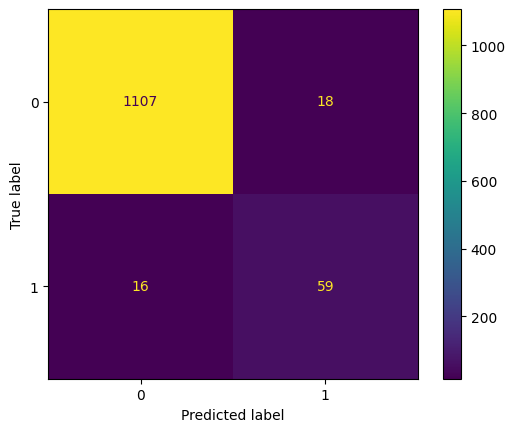

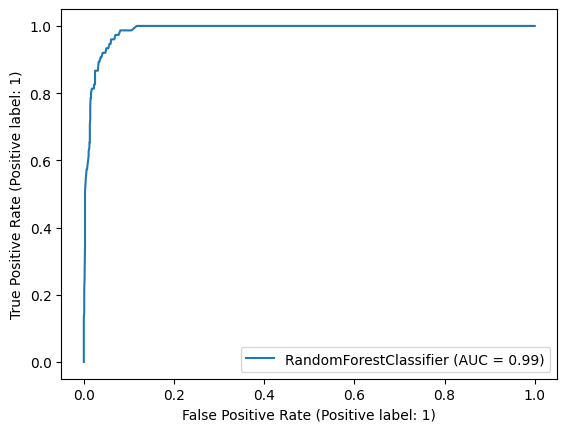

Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [02:46<00:00,  8.31s/it]


Abstraction level: 0.03
Abstraction data for d=0.03 does not exist, creating new one
abstract states: 7043
Concrete states 115730
ratio 0.06085716754514819
shape of data 7043
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9608333333333333


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.56
the test recall for the class no is 0.9875555555555555
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.75
the test precision for the class no is 0.9711538461538461
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.97      0.99      0.98      1125
       

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


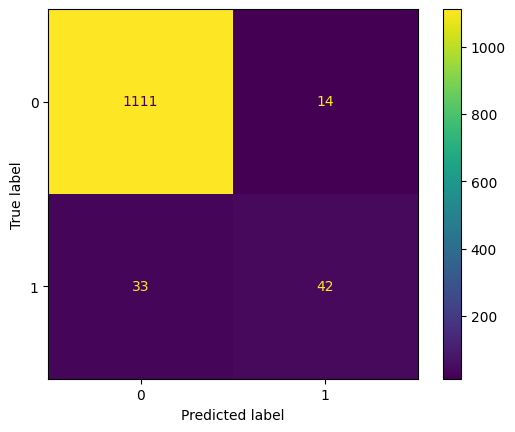

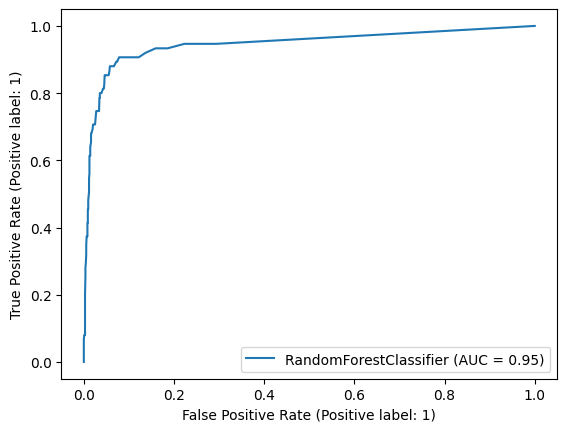

Abstraction data for d=0.03 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [04:19<00:00, 12.99s/it]


Abstraction level: 0.01
Abstraction data for d=0.01 does not exist, creating new one
abstract states: 54107
Concrete states 115730
ratio 0.4675278665860192
shape of data 54107
********************** reporting the result of the model **************************
The score for train data is 1.0
The score for test data is 0.9383333333333334


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.013333333333333334
the test recall for the class no is 1.0
the training recall for the class yes is 1.0
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 1.0
the test precision for the class no is 0.9382819015846539
the training precision for the class yes is 1.0
the training precision for the class no is 1.0



              precision    recall  f1-score   support

         NO        0.94      1.00      0.97      1125
      

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


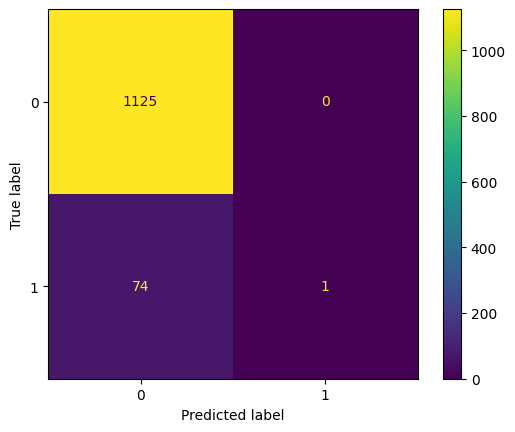

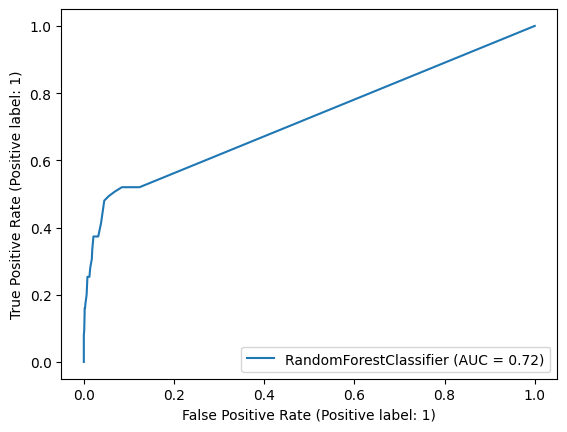

Abstraction data for d=0.01 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [21:03<00:00, 63.16s/it]


Abstraction level: 0.005
Abstraction data for d=0.005 does not exist, creating new one
abstract states: 97731
Concrete states 115730
ratio 0.8444742072064287
shape of data 97731
********************** reporting the result of the model **************************
The score for train data is 0.9996428571428572
The score for test data is 0.9375


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.0
the test recall for the class no is 1.0
the training recall for the class yes is 0.9931972789115646
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.0
the test precision for the class no is 0.9375
the training precision for the class yes is 1.0
the training precision for the class no is 0.9996232102486813



              precision    recall  f1-score   support

         NO        0.94      1.00      0.97      1125


c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student

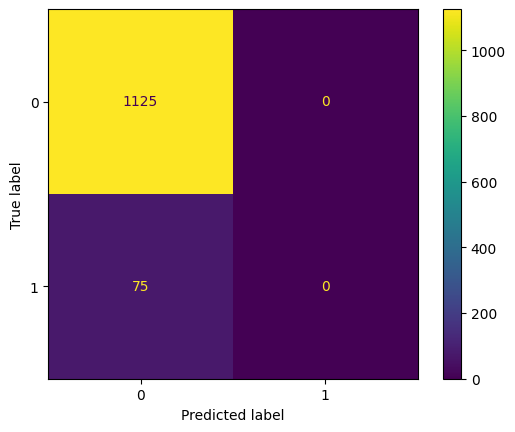

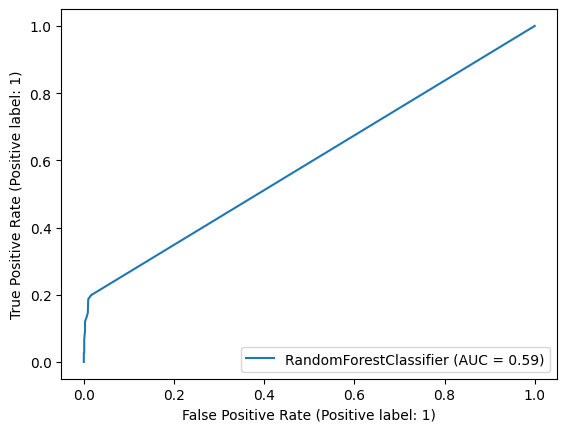

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student

Abstraction data for d=0.005 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [38:40<00:00, 116.05s/it]


Abstraction level: 0.001
Abstraction data for d=0.001 does not exist, creating new one
abstract states: 115357
Concrete states 115730
ratio 0.9967769809038278
shape of data 115357
********************** reporting the result of the model **************************
The score for train data is 0.9992857142857143
The score for test data is 0.9375


--------------------------------------recall---------------------------------
the test recall for the class yes is 0.0
the test recall for the class no is 1.0
the training recall for the class yes is 0.9863945578231292
the training recall for the class no is 1.0


--------------------------------------precision------------------------------
the test precision for the class yes is 0.0
the test precision for the class no is 0.9375
the training precision for the class yes is 1.0
the training precision for the class no is 0.9992467043314501



              precision    recall  f1-score   support

         NO        0.94      1.00      0.97      112

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student

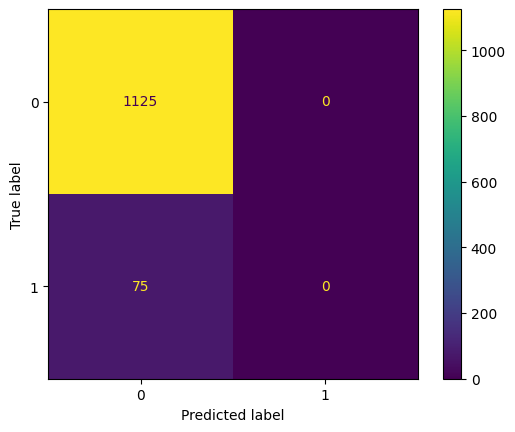

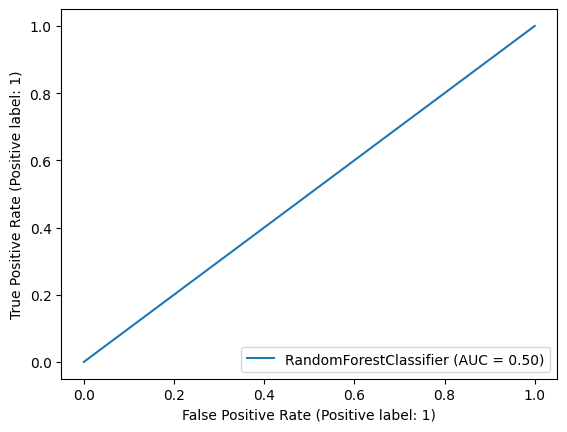

c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student\anaconda-updated\envs\RayTF\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Student

Abstraction data for d=0.001 does not exist, creating new one
Number of episodes to plot: 200


Plotting: 100%|██████████| 20/20 [49:33<00:00, 148.67s/it]


: 

In [24]:
from tqdm import tqdm
model  = DQN.load("HighwayEnv/training_checkpoints_CP_10_arch_64by2/SB3_DQN_highway_fast_50sec_CP10_arch_64by2_70000_steps.zip")
threshold = 30

d_set= [0.06,0.03,0.01, 0.005,0.001]

#load ml training data
with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_test_4000_SV222_Rate0.0555.pkl', 'rb') as file2:
    final_episodes = pickle.load(file2)
# with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch128_SV370_Rate0.185.pkl\episodes_final_test_2100_SV432_Rate0.2057142857142857.pkl', 'rb') as file2:
#     final_episodes2 = pickle.load(file2)


# final_episodes2 = final_episodes2[:2000]

# final_episodes = final_episodes1 + final_episodes2

# #memory freeup
# del final_episodes1
# del final_episodes2
# gc.collect()
final_episodes = final_episodes[:4000]
final_episodes = build_episodes(final_episodes)

print("Number of functional faults in the final episodes:",number_of_functional_faults(final_episodes,threshold))

with open(f'HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch64_SV222_Rate0.0555.pkl\episodes_final_val_1000_SV59_Rate0.059.pkl', 'rb') as file2:
    FRT = pickle.load(file2)
# FRT = FRT[4000:]
FRT = build_episodes(FRT)

print("Number of functional faults in the test episodes:",number_of_functional_faults(FRT,threshold))

for d in d_set:
    print(f"Abstraction level: {d}")
    Read_from_data = False
    my_path = f'Main_Data_Freq_agent6_70k_30steps/ABS/Abstraction_data_final_{d}.pickle'


    if not os.path.exists(my_path):
        print(f"Abstraction data for d={d} does not exist, creating new one")
        os.makedirs(os.path.dirname(my_path), exist_ok=True)
    if Read_from_data:
        with open(my_path, 'rb') as file2:
            unique1 = pickle.load(file2)
        uni1=np.array(unique1)
    if not Read_from_data:
        unique1= Abstract_classes(final_episodes,d,model)
        with open(my_path, 'wb') as file2:
            pickle.dump(unique1, file2)


    data1_x_b, data1_y_f_b = ML_second_representation_func_based(d,is_functional_fault,
                                                                model,final_episodes,
                                                                unique1, threshold)

    print("shape of data",len(data1_x_b[0]))
    #########################################################  Train ML - Functional fault predictor #############


    X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(data1_x_b, data1_y_f_b, test_size=0.30, random_state=42)
    RF_FF_1rep = RandomForestClassifier(random_state=0, class_weight='balanced')
    RF_FF_1rep.fit(X_train_f,y_train_f)
    report_path = 'Main_Data_Freq_agent6_70k_30steps/Reports'
    if not os.path.exists(report_path):
        os.makedirs(report_path, exist_ok=True)
    report_and_save(RF_FF_1rep,X_train_f,y_train_f,X_test_f,y_test_f,save=True,abs_d=d,save_path=report_path)
    #save RF_FF_1rep
    save_path_model = f'Main_Data_Freq_agent6_70k_30steps/ML_models/RF_FF_1rep_{d}.pickle'
    if not os.path.exists(save_path_model):
        print(f"Abstraction data for d={d} does not exist, creating new one")
        os.makedirs(os.path.dirname(save_path_model), exist_ok=True)
    with open(save_path_model, 'wb') as file2:
        pickle.dump(RF_FF_1rep, file2)



    # with open(f'Main_Data_agent_70k/ML_models/RF_FF_1rep_{d}.pickle', 'rb') as file2:
    #     RF_FF_1rep = pickle.load(file2)
    #read FRT and FRTS from pickle
    # with open(f'\HighwayEnv\Data\Episodes\Episodes_DQN_CP_10_70_000_steps_arch128_SV370_Rate0.185.pkl\episodes_final_val_1000_SV167_Rate0.167.pkl', 'rb') as file2:
    #     FRT = pickle.load(file2)
    # # FRT = FRT[4000:]
    # FRT = build_episodes(FRT)
    par = [d,unique1,model,RF_FF_1rep]

    #########################################################  Plot Risk and Position #############
    Run_number = 10
    newpath = f'c:\\Users\\Student\\Desktop\\vs_git\\HazardDetection\\Highway\\RUN_{Run_number}_CI_Plots_agent_6_70k_30steps\\Abs_{d}'
    if not os.path.exists(newpath):
        os.makedirs(newpath)
    Num_plot = 200 #number of episodes to plot
    if len(FRT)<Num_plot:
        print("number of available episodes is less than {Num_plot}}")
        Num_plot = len(FRT)
    print("Number of episodes to plot:",Num_plot)
    for i in tqdm(range(0,Num_plot,10), desc="Plotting", total=Num_plot//10):
        Forest_CI_multiple(translate_multiple_episodes_steps(FRT[i:i+10],model,translator_frequency,d,unique1),RF_FF_1rep,i,d,threshold,path=newpath)
    